# Testing effects of PSD vs non-PSD in directed/undirected, and making sure latent positions are correct in directed case

In [1]:
import numpy as np
import pandas as pd
import graspologic as gs
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from sklearn.utils.validation import check_is_fitted

from graspologic.embed import AdjacencySpectralEmbed as ASE
from graspologic.simulations import sbm
from graspologic.utils import remove_vertices
from graspologic.plot import pairplot, heatmap

np.random.seed(9002)
np.set_printoptions(suppress=True)

# Define plotting function, check in 2D

In [2]:
# create sbm
def graph(P, directed=False, diag_aug=False, reverse_pred=False, suppress_text=False, n=100, title=None):
    n_components = P.shape[0]
    ase = ASE(n_components=n_components, diag_aug=diag_aug)
    directed_g, labels = sbm([n]*n_components, P, 
                           return_labels=True, directed=directed)

    # generate labels
    oos_idx = np.nonzero(np.r_[1, np.diff(labels)[:-1]])[0]  # grab one from each community
    labels = list(labels)
    oos_labels = [labels.pop(i) for i in oos_idx]

    # grab oos indices
    A, a = remove_vertices(directed_g, indices=oos_idx, return_removed=True)
    print(f"A is type {type(A)}")

    if directed:
        latent_left, latent_right = ase.fit_transform(A)
    else:
        latent_left = ase.fit_transform(A)

    if reverse_pred and directed:
        w = ase.transform(a[::-1])  # reverses tuple order from `remove_vertices`
    else:
        w = ase.transform(a)
    
    if directed:
        print(f"w should be a tuple. w is type {type(w)}")
        w_left, w_right = w
    else:
        w_left = w

    # print results
    if not suppress_text:
        print(f"left latent positions (sample from same communities): \n{latent_left[oos_idx, :]}\n")
        print(f"left prediction: \n{w_left}\n\n")
        
        if directed:
            print(f"right latent positions (sample from same communities): \n{latent_right[oos_idx, :]}\n")
            print(f"right prediction: \n{w_right}")
    
    # labels dataframes
    df_labels = pd.DataFrame(labels, columns=["Type"])
    df_oos_labels = pd.DataFrame(oos_labels, columns=["Type"])

    # left dataframes
    out_oos_df = pd.concat([df_oos_labels, pd.DataFrame(w_left)], axis=1)
    out_oos_df.columns = ["Type"]+[f"Dimension {d+1}" for d in range(P.shape[0])]

    g = pairplot(latent_left, labels=labels, title=title + ", Out" if title else None)
    g.data = out_oos_df
    g.hue_vals = out_oos_df["Type"]
    g.map_offdiag(plt.scatter, s=500, marker="*", edgecolor="black")
    
    # in dataframes
    if directed:
        in_oos_df = pd.concat([df_oos_labels, pd.DataFrame(w_right)], axis=1)
        in_oos_df.columns = ["Type"]+[f"Dimension {d+1}" for d in range(P.shape[0])]

        h = pairplot(latent_right, labels=labels, title=title + ", In" if title else None)
        h.data = in_oos_df
        h.hue_vals = in_oos_df["Type"]
        h.map_offdiag(plt.scatter, s=500, marker="*", edgecolor="black")

### check that pairwise distances are correct

e.g., generate latent positions for three communities, and transform an out-of-sample node for each community.  
Take the mean for each community. Check that each out-of-sample node is closer to the mean of the community it belongs to (in euclidean distance) than the mean of any other community.  
Added as a test in the implementation as well.

In [3]:
P = np.array([[0.9, 0.1, 0.1], 
              [0.3, 0.6, 0.1], 
              [0.1, 0.5, 0.6]])

ase = ASE(n_components=3)
directed_g, labels = sbm([200]*3, P, 
                       return_labels=True, directed=True)

# generate labels
oos_idx = np.nonzero(np.r_[1, np.diff(labels)[:-1]])[0]  # grab one from each community
labels = list(labels)
oos_labels = [labels.pop(i) for i in oos_idx]

# grab oos indices
A, a = remove_vertices(directed_g, indices=oos_idx, return_removed=True)

# transform
latent_left, latent_right = ase.fit_transform(A)
w_left, w_right = ase.transform(a)

df_left = pd.DataFrame({"Type": labels, 
                       "Dimension 1": latent_left[:, 0],
                       "Dimension 2": latent_left[:, 1],
                       "Dimension 3": latent_left[:, 2]})
means_left = df_left.groupby("Type").mean()

distances_ll = np.diag(pairwise_distances(means_left, w_left))
distances_lr = np.diag(pairwise_distances(means_left, w_right))

print(distances_ll)
print(distances_lr)

[0.02323243 0.03788254 0.04129354]
[0.13556714 0.32073846 0.2918007 ]


In [4]:
all(distances_ll < distances_lr)

True

## Check positive semidefinite matrix

A is type <class 'numpy.ndarray'>
left latent positions (sample from same communities): 
[[ 0.740201   -0.59606161]
 [ 0.69276482  0.53106706]]

left prediction: 
[[ 0.6280656  -0.49406964]
 [ 0.70775938  0.55828298]]




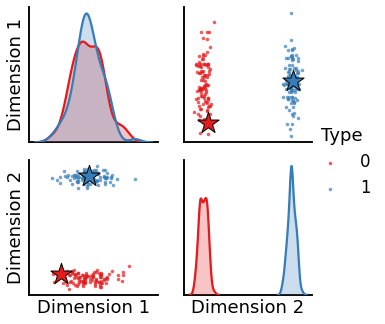

In [5]:
P = np.array([[0.8, 0.2],
              [0.2, 0.8]])

graph(P, directed=False)

In [6]:
P.shape[0]
[f"Dimension {d+1}" for d in range(P.shape[0])]

['Dimension 1', 'Dimension 2']

## Check non positive-semidefinite matrix

anton mentioned that issues pop up when matrices aren't psd, this shows that out-of-sample predictions get reversed.  
I'm thinking it'd be prudent to add a warning into the embedding code that mentions this issue if there are any negative eigenvalues.

In [7]:
P = np.array([[0.2, 0.8],
              [0.8, 0.2]])
# Showing negative eigenvalue
vals, _ = np.linalg.eig(P)
vals

array([ 1. , -0.6])

A is type <class 'numpy.ndarray'>
left latent positions (sample from same communities): 
[[ 0.77085952 -0.53510384]
 [ 0.75036563  0.58101262]]

left prediction: 
[[ 0.71763102  0.57789019]
 [ 0.70030996 -0.55098467]]




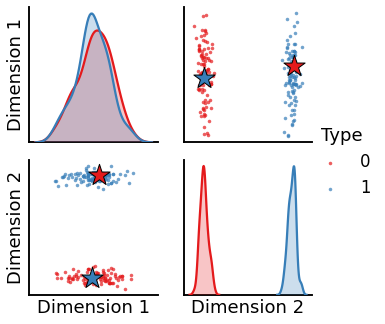

In [8]:
graph(P, directed=False)

... But this isn't true in the directed case.

A is type <class 'numpy.ndarray'>
w should be a tuple. w is type <class 'tuple'>
left latent positions (sample from same communities): 
[[ 0.70462369 -0.58660665]
 [ 0.70567838  0.54919781]]

left prediction: 
[[ 0.73086121 -0.46219078]
 [ 0.73538257  0.48331762]]


right latent positions (sample from same communities): 
[[ 0.68526106  0.49905901]
 [ 0.66543155 -0.6034336 ]]

right prediction: 
[[ 0.66103215  0.5058996 ]
 [ 0.72696568 -0.6136306 ]]


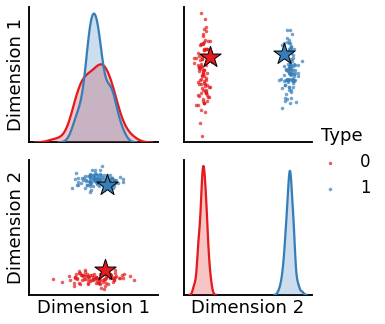

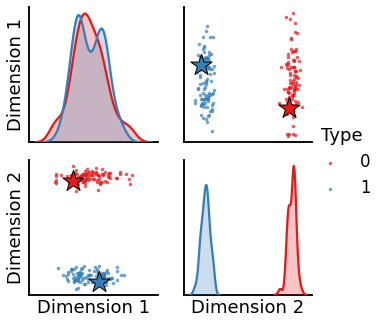

In [9]:
graph(P, directed=True)

## 3D

#### undirected case (PSD)

In [10]:
P = np.array([[0.8, 0.3, 0.1], 
              [0.3, 0.6, 0.1], 
              [0.1, 0.1, 0.6]])
vals, _ = np.linalg.eig(P)
vals  # PSD

array([1.05877415, 0.3810466 , 0.56017926])

A is type <class 'numpy.ndarray'>
A is type <class 'numpy.ndarray'>


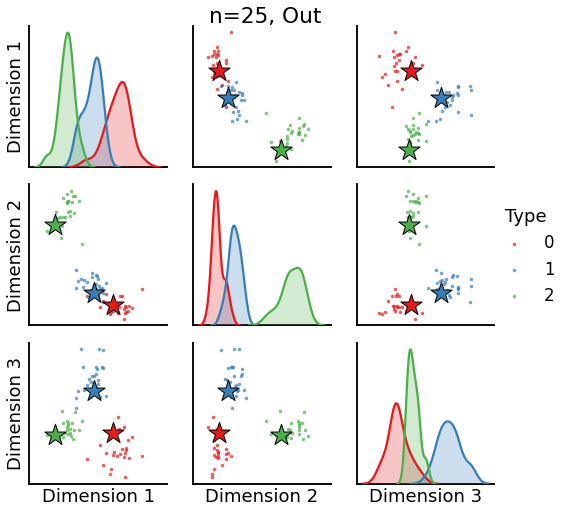

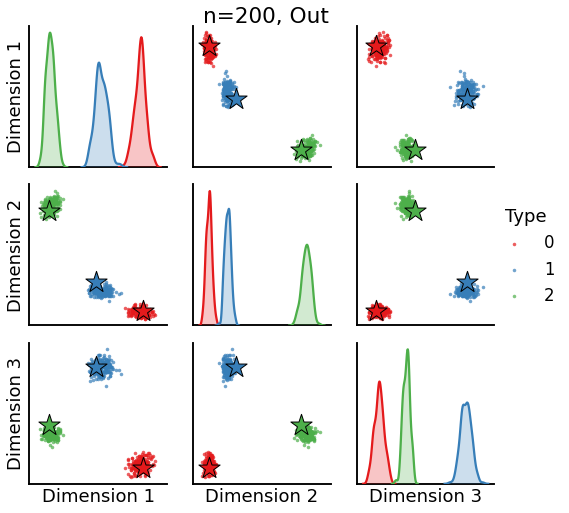

In [11]:
for n in [25, 200]:
    graph(P, directed=False, diag_aug=True, suppress_text=True, n=n, title=f"n={n}")

#### undirected case (not PSD)

In [12]:
P = np.array([[0.3, 0.8, 0.6], 
              [0.8, 0.1, 0.6], 
              [0.6, 0.6, 0.1]])
vals, _ = np.linalg.eig(P)
vals  # not PSD

array([ 1.51394432, -0.6163592 , -0.39758512])

A is type <class 'numpy.ndarray'>
A is type <class 'numpy.ndarray'>


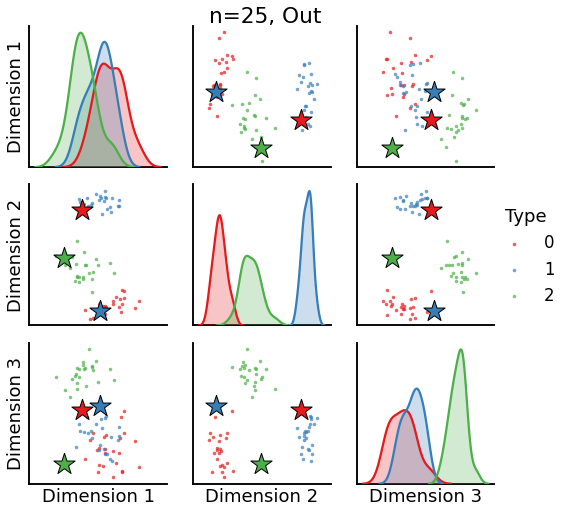

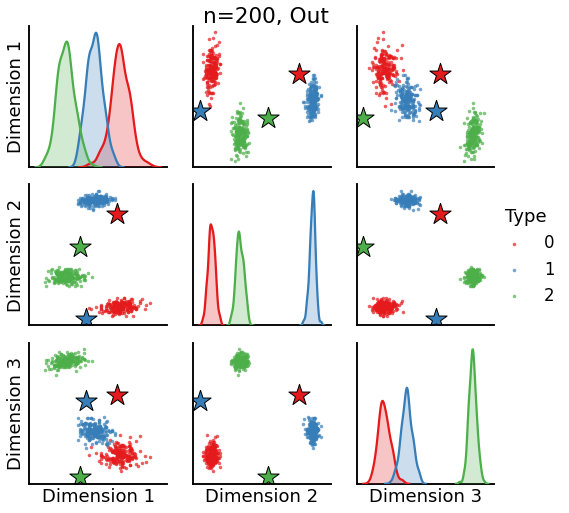

In [13]:
# off, because again, matrix is not positive semi-definite and has negative eigenvalues
for n in [25, 200]:
    graph(P, directed=False, diag_aug=True, suppress_text=True, n=n, title=f"n={n}")

#### directed case (psd)

In [14]:
import sklearn

P = np.array([[0.9, 0.6, 0.6], 
              [0.1, 0.9, 0.6], 
              [0.1, 0.1, 0.9]])

_, vals, _ = sklearn.utils.extmath.randomized_svd(P, n_components=3)
vals  # PSD

array([1.67551705, 0.64182441, 0.56630736])

A is type <class 'numpy.ndarray'>
w should be a tuple. w is type <class 'tuple'>
A is type <class 'numpy.ndarray'>
w should be a tuple. w is type <class 'tuple'>


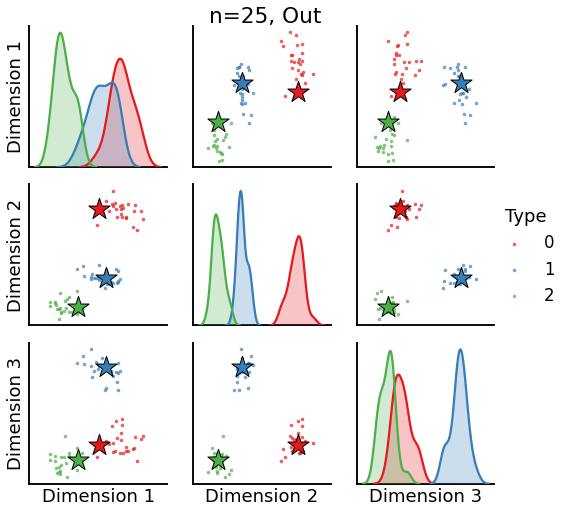

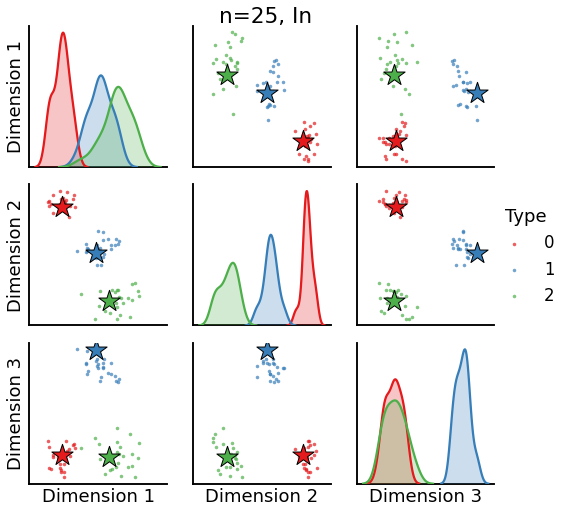

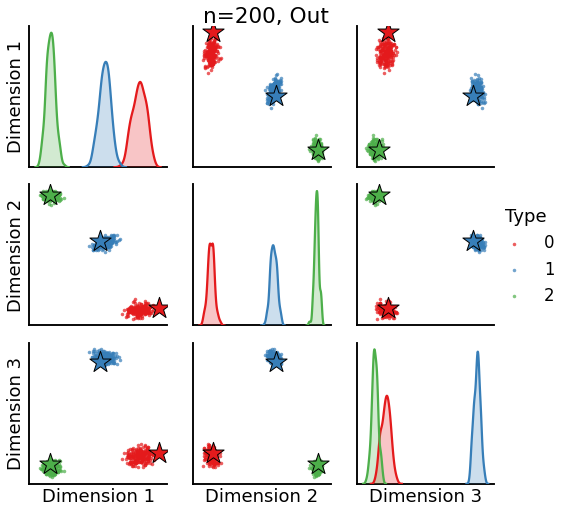

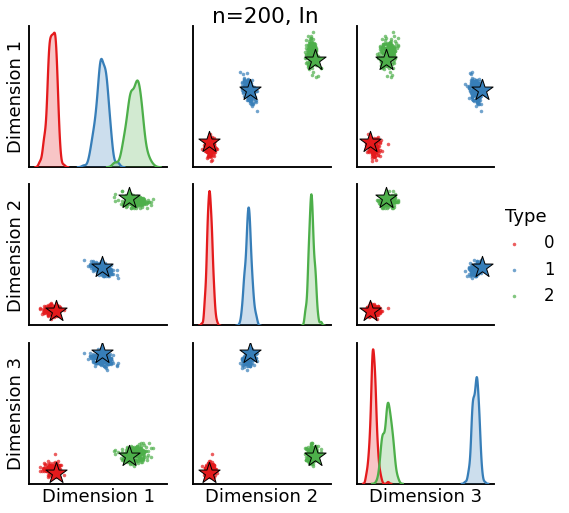

In [15]:
for n in [25, 200]:
    graph(P, directed=True, diag_aug=True, suppress_text=True, n=n, title=f"n={n}")

#### directed case (not psd)

In [16]:
P = np.array([[0.3, 0.8, 0.6], 
              [0.8, 0.1, 0.6], 
              [0.6, 0.6, 0.1]])
vals, _ = np.linalg.eig(P)
vals  # not PSD

array([ 1.51394432, -0.6163592 , -0.39758512])

A is type <class 'numpy.ndarray'>
w should be a tuple. w is type <class 'tuple'>
A is type <class 'numpy.ndarray'>
w should be a tuple. w is type <class 'tuple'>


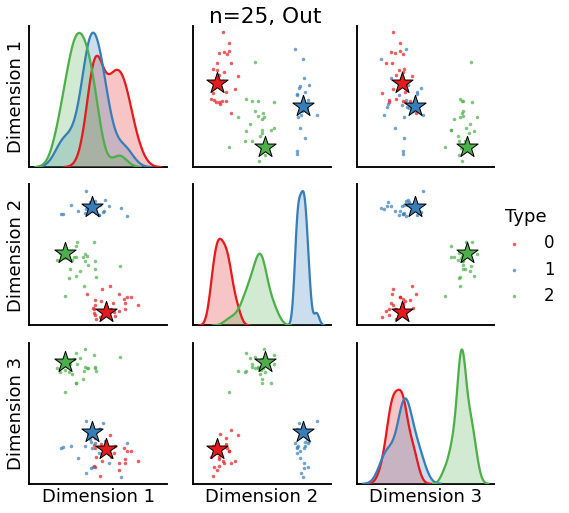

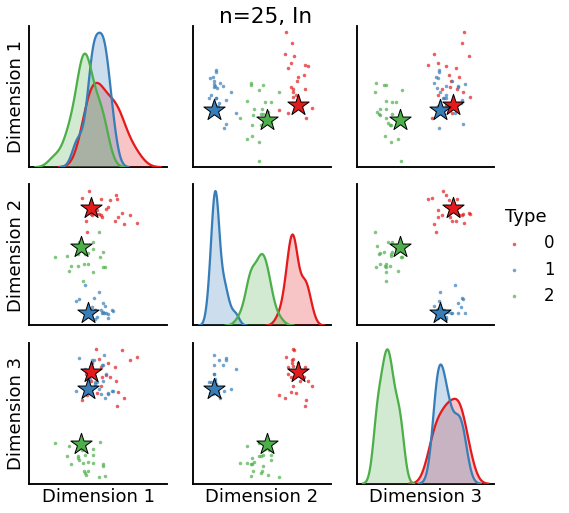

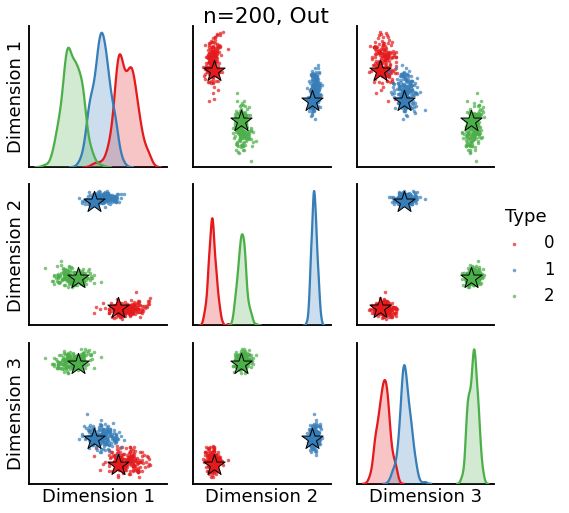

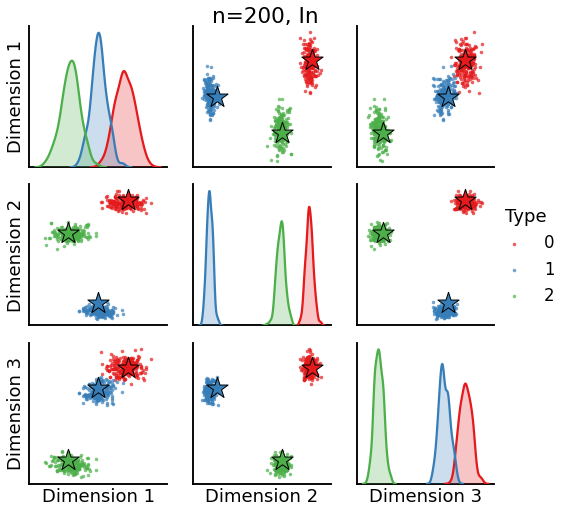

In [17]:
for n in [25, 200]:
    graph(P, directed=True, suppress_text=True, n=n, title=f"n={n}")

## reversing vertices in remove_vertices in directed case

In [18]:
P = np.array([[0.9, 0.1, 0.1], 
              [0.3, 0.6, 0.1], 
              [0.1, 0.5, 0.6]])

vals, _ = np.linalg.eig(P)
vals  # PSD

array([1.08844837, 0.58842506, 0.42312657])

#### `A, a = remove_vertices(...)` -> `a = a[::-1]`

(where a is type `tuple`)

A is type <class 'numpy.ndarray'>
w should be a tuple. w is type <class 'tuple'>
left latent positions (sample from same communities): 
[[ 0.71697815  0.59983561 -0.09778092]
 [ 0.5603802  -0.23224113  0.47986886]
 [ 0.59159801 -0.59949267 -0.21516494]]

left prediction: 
[[ 0.82665352  0.46405987  0.01427652]
 [ 0.60829992 -0.5855398  -0.05375497]
 [ 0.32889465 -0.31502568 -0.72401562]]


right latent positions (sample from same communities): 
[[ 0.74646383  0.54575761  0.02304872]
 [ 0.64734915 -0.46131161  0.30195668]
 [ 0.39287975 -0.33108892 -0.43647749]]

right prediction: 
[[ 0.63752834  0.60283947 -0.25580197]
 [ 0.49511454 -0.04295525  0.66170436]
 [ 0.60764786 -0.5063657   0.10841282]]


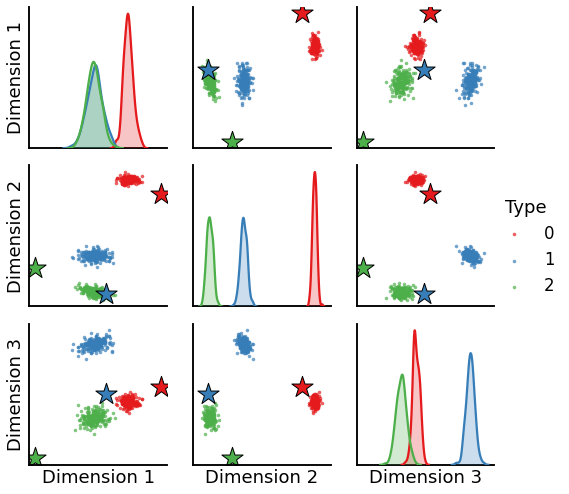

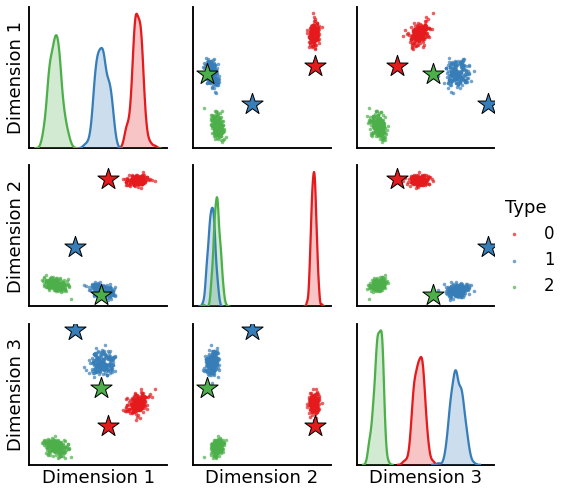

In [19]:
# should be wrong
graph(P, directed=True, reverse_pred=True, n=200)

#### reversing return order in transform method and reversing return order in `remove_vertices`

In [20]:
def transform(self, X):
    # just fit_transform if X is the matrix we fit to
    if np.array_equal(X, self._A):
        return self._fit_transform(X, prefit=True)

    # checks
    check_is_fitted(self, "is_fitted_")
    directed = self.latent_right_ is not None

    # correct types?
    if directed and not isinstance(X, tuple):
        raise TypeError("Directed graphs require a tuple (X_out, X_in")
    if not directed and not isinstance(X, np.ndarray):
        raise TypeError("Undirected graphs require array input")

    # correct shape in y?
    latent_rows = self.latent_left_.shape[0]
    _X = X[0] if directed else X
    X_cols = _X.shape[-1]
    if _X.ndim > 2:
        raise ValueError("out-of-sample vertex must be 1d or 2d")
    if latent_rows != X_cols:
        msg = "out-of-sample vertex must be shape (n_oos_vertices, n_vertices)"
        raise ValueError(msg)

    # workhorse code
    if not directed:
        return X @ self._pinv_left
    elif directed:
        return X[0] @ self._pinv_left, X[1] @ self._pinv_right

In [21]:
ASE.transform = transform

## Check directed case (should be wrong)

A is type <class 'numpy.ndarray'>
w should be a tuple. w is type <class 'tuple'>
left latent positions (sample from same communities): 
[[ 0.8835239  -0.44080962 -0.29749073]
 [ 0.74850823  0.14195206  0.62525502]
 [ 0.55879074  0.58994511 -0.3921749 ]]

left prediction: 
[[ 0.53792884 -0.61226051 -0.4272624 ]
 [ 0.77279431 -0.23082152  0.60157071]
 [ 0.85689349  0.52643629 -0.21260512]]


right latent positions (sample from same communities): 
[[ 0.53565131 -0.61593083 -0.42124738]
 [ 0.73140515 -0.16822489  0.61645566]
 [ 0.8633038   0.50884981 -0.33931844]]

right prediction: 
[[ 0.87934888 -0.52498285 -0.29373203]
 [ 0.73905739  0.10829815  0.59990044]
 [ 0.56030652  0.59323763 -0.41343605]]


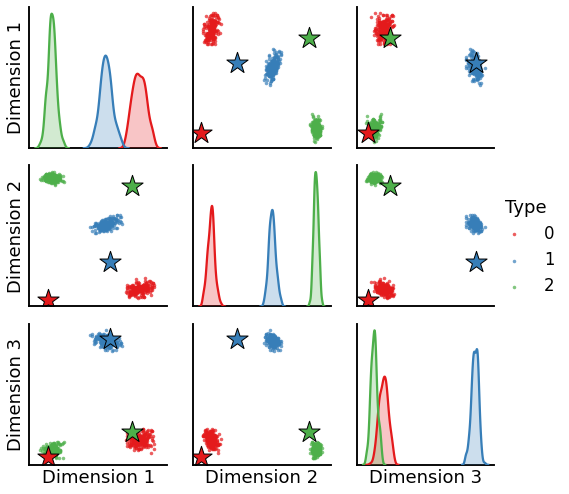

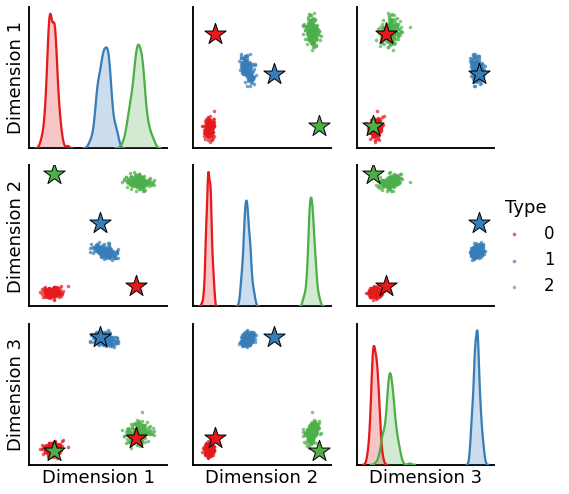

In [22]:
P = np.array([[0.9, 0.6, 0.6], 
              [0.1, 0.9, 0.6], 
              [0.1, 0.1, 0.9]])

graph(P, directed=True, n=200)

### reversing `remove_vertices` output (should be wrong)

A is type <class 'numpy.ndarray'>
w should be a tuple. w is type <class 'tuple'>
left latent positions (sample from same communities): 
[[ 0.86572428 -0.5382607  -0.26352066]
 [ 0.71265569  0.14918908  0.62970388]
 [ 0.53495259  0.63172023 -0.38764381]]

left prediction: 
[[ 0.97066027  0.00313603 -0.11970127]
 [ 0.6672401   0.7553365   0.49032039]
 [ 0.40144793  0.78745034 -0.5463293 ]]


right latent positions (sample from same communities): 
[[ 0.55845433 -0.59477333 -0.39744612]
 [ 0.75362458 -0.18601699  0.62367668]
 [ 0.88387983  0.50674488 -0.27346375]]

right prediction: 
[[ 0.39848452 -0.81585774 -0.58697216]
 [ 0.64283566 -0.73752466  0.48456936]
 [ 0.93577982  0.0248354  -0.13161777]]


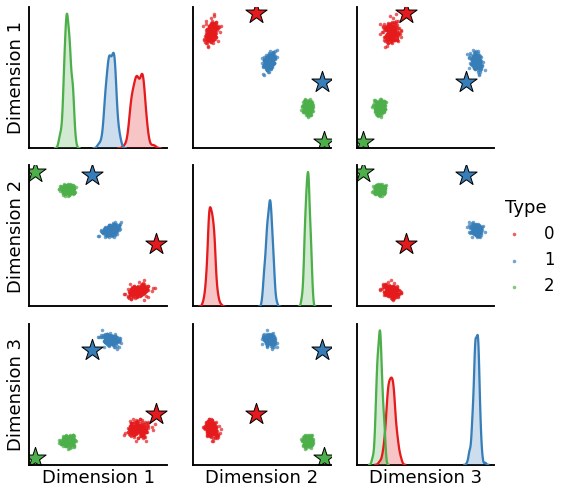

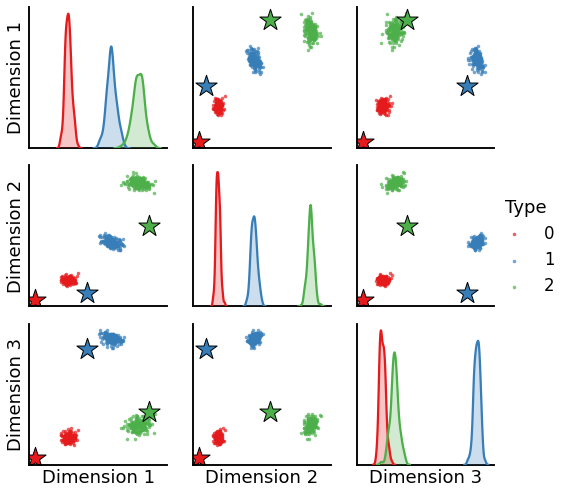

In [23]:
graph(P, directed=True, reverse_pred=True, n=200)

### without reversing `remove_vertices` output (should still be wrong)

A is type <class 'numpy.ndarray'>
w should be a tuple. w is type <class 'tuple'>
left latent positions (sample from same communities): 
[[ 0.88384187 -0.47688988 -0.29948294]
 [ 0.71355613  0.16769395  0.59511209]
 [ 0.54714471  0.59564569 -0.39693941]]

left prediction: 
[[ 0.53084473 -0.58054297 -0.44326309]
 [ 0.76238816 -0.1496906   0.59473343]
 [ 0.91826687  0.49123123 -0.28508542]]


right latent positions (sample from same communities): 
[[ 0.54522175 -0.57415042 -0.38454222]
 [ 0.76378883 -0.17706089  0.60249293]
 [ 0.89846004  0.51376562 -0.27260385]]

right prediction: 
[[ 0.93217751 -0.53707677 -0.25848713]
 [ 0.75219687  0.13634717  0.57815204]
 [ 0.53979608  0.602781   -0.42657699]]


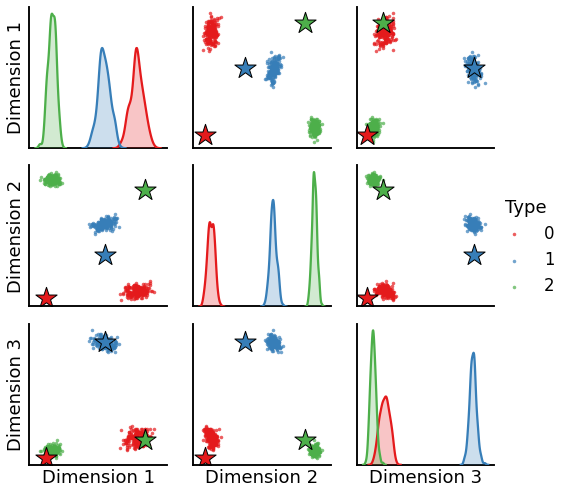

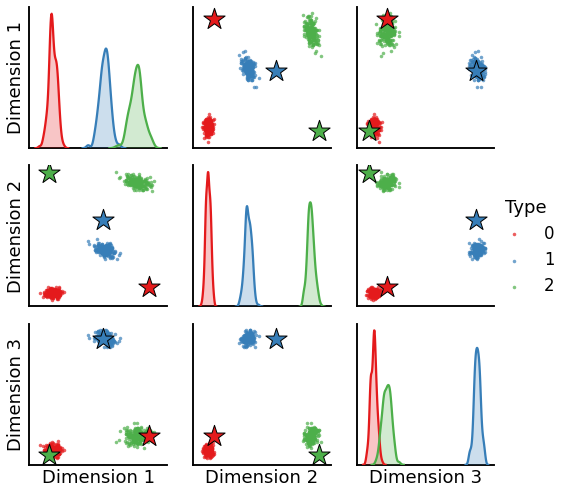

In [24]:
graph(P, directed=True, n=200)

#### Check directed case, reversed inputs, should be wrong

In [26]:
def transform(self, X):
    # just fit_transform if X is the matrix we fit to
    if np.array_equal(X, self._A):
        return self._fit_transform(X, prefit=True)

    # checks
    check_is_fitted(self, "is_fitted_")
    directed = self.latent_right_ is not None

    # correct types?
    if directed and not isinstance(X, tuple):
        raise TypeError("Directed graphs require a tuple (X_out, X_in")
    if not directed and not isinstance(X, np.ndarray):
        raise TypeError("Undirected graphs require array input")

    # correct shape in y?
    latent_rows = self.latent_left_.shape[0]
    _X = X[0] if directed else X
    X_cols = _X.shape[-1]
    if _X.ndim > 2:
        raise ValueError("out-of-sample vertex must be 1d or 2d")
    if latent_rows != X_cols:
        msg = "out-of-sample vertex must be shape (n_oos_vertices, n_vertices)"
        raise ValueError(msg)

    # workhorse code
    if not directed:
        return X @ self._pinv_left
    elif directed:
        return X[0] @ self._pinv_right, X[1] @ self._pinv_left
    
ASE.transform = transform

A is type <class 'numpy.ndarray'>
w should be a tuple. w is type <class 'tuple'>
left latent positions (sample from same communities): 
[[ 0.87517201 -0.55618676 -0.26727528]
 [ 0.76740924  0.11036226  0.65406645]
 [ 0.54406465  0.60040437 -0.38009541]]

left prediction: 
[[ 0.38746098 -0.76135445 -0.55104138]
 [ 0.66220589 -0.7134399   0.48977405]
 [ 0.95850001  0.01738174 -0.24424061]]


right latent positions (sample from same communities): 
[[ 0.54885034 -0.56453538 -0.36777661]
 [ 0.73986651 -0.18010396  0.60136794]
 [ 0.92039835  0.53424286 -0.30231513]]

right prediction: 
[[ 0.90962497 -0.07271557 -0.15381654]
 [ 0.69746174  0.68682126  0.49781336]
 [ 0.38219708  0.80113463 -0.56107584]]


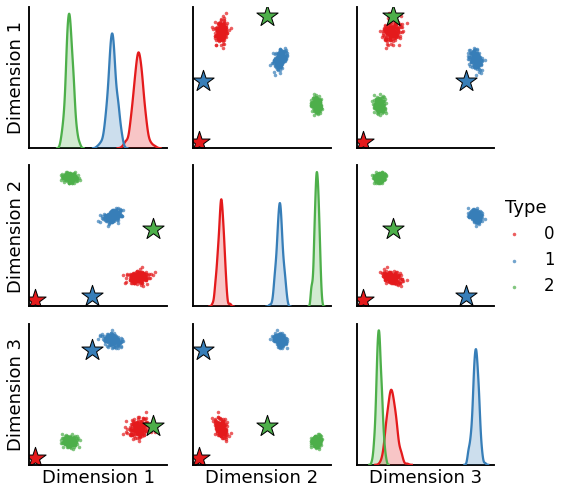

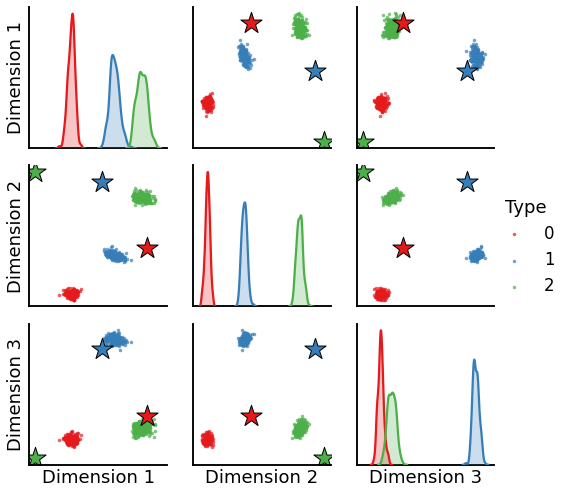

In [27]:
P = np.array([[0.9, 0.6, 0.6], 
              [0.1, 0.9, 0.6], 
              [0.1, 0.1, 0.9]])

graph(P, directed=True, n=200)